In [ ]:
pip install blocksnet

  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached pyarrow-12.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached pyarrow-12.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.1
    Uninstalling numpy-2.2.1:
      Successfully uninstalled numpy-2.2.1
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.16 requires dask==2024.10.0, which is not installed.
albucore 0.0.19 requires numpy>=1.24.4, but you

In [ ]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 2.2 MB/s eta 0:00:00


In [ ]:
import os
import osmnx as ox
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import box
import numpy as np
from scipy.spatial import Voronoi
from shapely.ops import unary_union
import random
import networkx as nx
from shapely.geometry import LineString
import matplotlib.patches as mpatches

In [ ]:
# делаем короткий путь к системе координат и путь к файлам в хранилище в колабе
local_crs = 32636
data_path = '/content/'

ДЕЛАЕМ БЛОКИ ДЛЯ БУДУЩЕГО РАСПРЕДЕЛЕНИЯ ЛЭНДЮЗА

In [ ]:
# загружаем наш участок без водных объектов
landplot = gpd.read_file(os.path.join(data_path, 'shlis_no_water.geojson')).to_crs(local_crs)

In [ ]:
# делаем полигон из нашего объекта
landplot_poly = landplot.geometry[0]

In [ ]:
# создаём рандомные точки по карте. в дальнейшем мы будем использовать их, чтобы построить полигоны Вороного
import numpy as np
from shapely.geometry import Point
import geopandas as gpd

def generate_random_points(landplot_poly, num_points):
    points = []
    minx, miny, maxx, maxy = landplot_poly.bounds

    while len(points) < num_points:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))

        # внутри полигона ли точка
        if landplot_poly.contains(random_point):
            points.append(random_point)

    return points

# 190 рандомных точек
random_points = generate_random_points(landplot_poly, 190)

# гдф точек
points_gdf = gpd.GeoDataFrame(geometry=random_points)

In [ ]:
# создаём рандомные точки на границе. это нужно сделать, чтобы максимально заполнить полигонами Вороного пространство вплоть до границ
# без них полигоны закончатся до границ
from shapely.geometry import MultiPolygon, Polygon

def generate_boundary_points(landplot_poly, num_points):
    boundary_points = []

    # проверяем, мультиполигон ли это
    if isinstance(landplot_poly, MultiPolygon):
        for sub_polygon in landplot_poly.geoms:
            boundary = sub_polygon.exterior
            boundary_length = boundary.length
            distances = np.linspace(0, boundary_length, num_points // len(landplot_poly.geoms))
            boundary_points.extend([boundary.interpolate(distance) for distance in distances])
    elif isinstance(landplot_poly, Polygon):
        boundary = landplot_poly.exterior
        boundary_length = boundary.length
        distances = np.linspace(0, boundary_length, num_points)
        boundary_points = [boundary.interpolate(distance) for distance in distances]
    else:
        raise ValueError("Input must be a Polygon or MultiPolygon")

    return boundary_points
boundary_points = generate_boundary_points(landplot_poly, 247)

In [ ]:
# объединяем просто рандомные точки и точки с границ
all_points = random_points + boundary_points

In [ ]:
# переводим в гдф
points_gdf = gpd.GeoDataFrame(geometry=all_points)

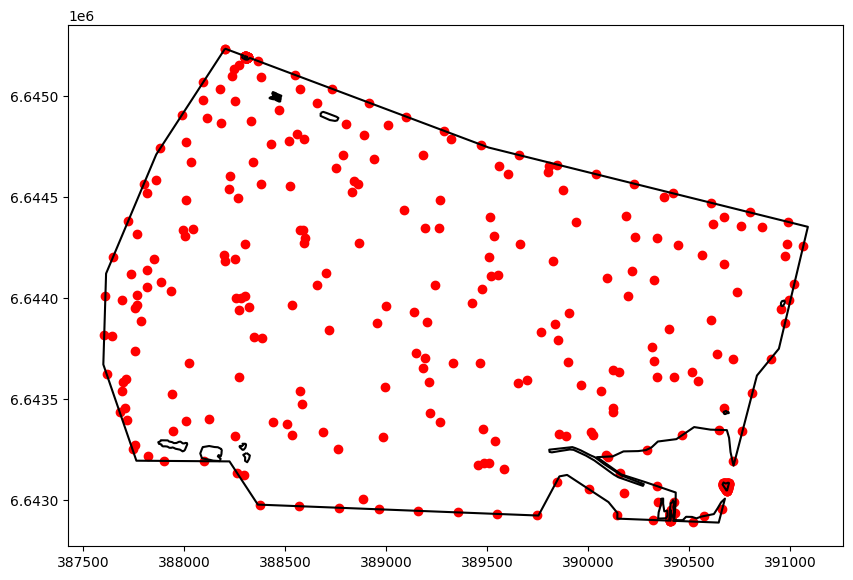

In [ ]:
# рисуем точки на карте
fig, ax = plt.subplots(figsize=(10, 10))
landplot.boundary.plot(ax=ax, edgecolor="black")
points_gdf.plot(ax=ax, color="red")
plt.show()

In [ ]:
# создаём функцию для генерации полигонов Вороного
def create_voronoi_polygons(all_points, landplot_poly):
    coords = np.array([point.coords[0] for point in all_points])
    vor = Voronoi(coords)
    voronoi_polygons = []
    for region_index in vor.regions:
        if not region_index or -1 in region_index:
            continue
        region_coords = [vor.vertices[i] for i in region_index]
        polygon = Polygon(region_coords)
        clipped_polygon = polygon.intersection(landplot_poly)
        if not clipped_polygon.is_empty:
            voronoi_polygons.append(clipped_polygon)
    return voronoi_polygons

voronoi_polygons = create_voronoi_polygons(all_points, landplot_poly)

In [ ]:
# переводим в гдф
voronoi_gdf = gpd.GeoDataFrame(geometry=voronoi_polygons)

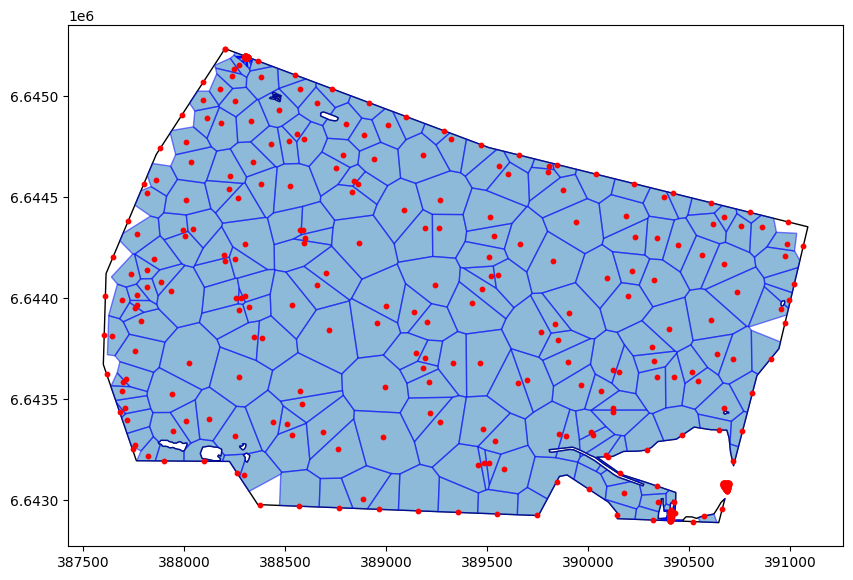

In [ ]:
# делаем визуализацию границ участка, точек и полигонов
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoSeries(landplot_poly).plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
voronoi_gdf.plot(ax=ax, alpha=0.5, edgecolor='blue')
points_gdf = gpd.GeoDataFrame(geometry=all_points)
points_gdf.plot(ax=ax, color='red', markersize=10)

plt.show()

In [ ]:
# собираем все полигоны Вороного в одну геометрию
voronoi_union = unary_union(voronoi_gdf.geometry)


In [ ]:
# находим разницу между полигоном участка и общим полигоном Вороного из предыдущего этапа
gaps = landplot_poly.difference(voronoi_union)

In [ ]:
# создаём список пробелов от границы участка до общего полигона Вороного, таким образуются полигоны, заполняющие пустоты
gaps_list = []
if isinstance(gaps, (Polygon, MultiPolygon)):
    if gaps.is_empty:
        print("No gaps found.")
    elif gaps.geom_type == 'Polygon':
        gaps_list = [gaps]
    elif gaps.geom_type == 'MultiPolygon':
        gaps_list = list(gaps.geoms)


In [ ]:
# превращаем гэпы в гдф и объединяем в один файл с полигонами Вороного (voronoi_gdf)
if gaps_list:
    gaps_gdf = gpd.GeoDataFrame(geometry=gaps_list)
    # соединяем Вороного с заполняющими блоками
voronoi_gdf = pd.concat([voronoi_gdf, gaps_gdf], ignore_index=True)

<function matplotlib.pyplot.show(close=None, block=None)>

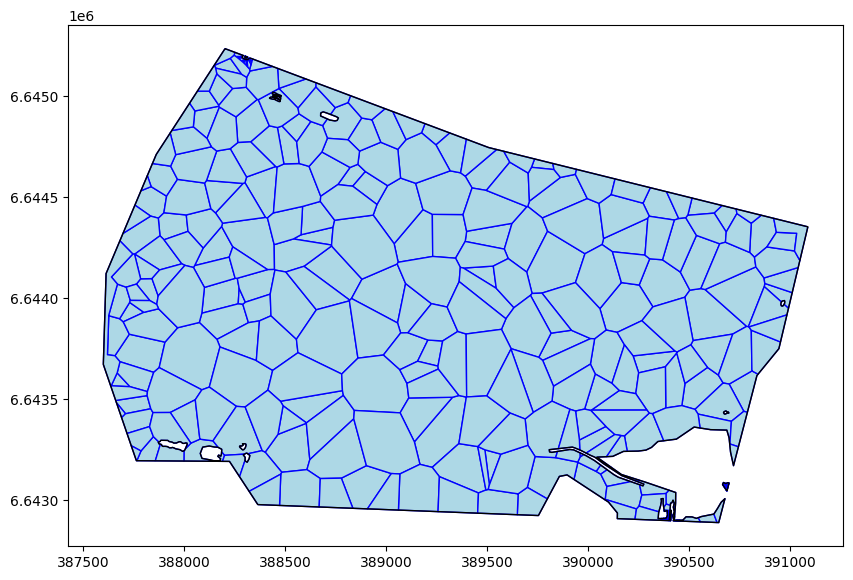

In [ ]:
# визуализация деления на участки
fig, ax = plt.subplots(figsize=(10, 10))
voronoi_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='blue')
gpd.GeoSeries(landplot_poly).plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
plt.show

In [ ]:
blocks_for_task = voronoi_gdf.set_crs(32636)

# качаем файлик
output_file = 'blocks_for_task.geojson'
blocks_for_task.to_file(output_file, driver='GeoJSON')

print(f'GeoJSON file saved with CRS 32636 as {output_file}')

GeoJSON file saved with CRS 32636 as blocks_for_task.geojson


РАСПРЕДЕЛЕНИЕ ЛЭНДЮЗА С ПОМОЩЬЮ БЛОКСНЕТА

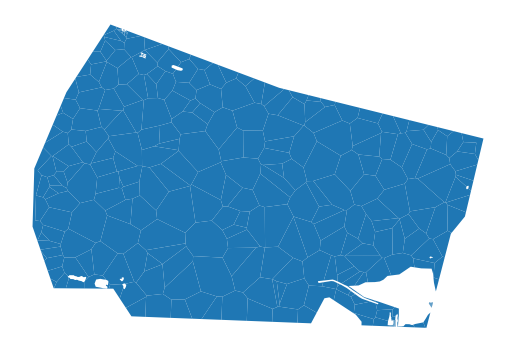

In [ ]:
# называем полигоны блоками, делаем у них буферы, визуализируем
blocks_gdf=voronoi_gdf
blocks_gdf = gpd.GeoDataFrame(blocks_gdf.geometry.explode(True)).reset_index(drop=True)
blocks_gdf.plot().set_axis_off()

In [ ]:
# тут можно посмотреть список наших полигончиков
blocks_gdf

,geometry
0,"POLYGON ((389230.779 6644208.02, 389059.755 66..."
1,"POLYGON ((388240.999 6644255.569, 388223.268 6..."
2,"POLYGON ((388412.85 6644142.841, 388240.999 66..."
3,"POLYGON ((387816.89 6643519.027, 387835.041 66..."
4,"POLYGON ((387709.971 6643429.178, 387690.425 6..."
...,...
490,"POLYGON ((387599.975 6643673.256, 387613.645 6..."
491,"POLYGON ((387756.319 6644462.059, 387834.148 6..."
492,"POLYGON ((387817.883 6644608.21, 387836.705 66..."
493,"POLYGON ((387861.999 6644712.938, 387931.053 6..."


In [ ]:
# проверяем, все ли геометрии доступны
blocks_gdf = blocks_gdf[blocks_gdf['geometry'].is_valid]

In [ ]:
# оставляем только полигоны и мультиполигоны
blocks_gdf = blocks_gdf[blocks_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

In [ ]:
# удаляем пустые блоки
blocks_gdf = blocks_gdf[~blocks_gdf.geometry.is_empty]

# удаляем блоки без геометрии
blocks_gdf = blocks_gdf.dropna(subset=['geometry'])

In [ ]:
# запускаем нашем лэндюз оптимайзер и начинаем молиться
luo = LandUseOptimizer(blocks_gdf)
luo.blocks.plot().set_axis_off()

NameError: name 'LandUseOptimizer' is not defined

In [ ]:
# распределяем пропорции (суммарно должно быть 1) для разных зон. можно не стараться, он всё равно распределит их на великом рандоме (и не сделает зону жилой застройки))))))))
from blocksnet import LandUse

lu_shares = {
  LandUse.RESIDENTIAL: 0.3,
  LandUse.BUSINESS: 0.15,
  LandUse.RECREATION: 0.25,
  LandUse.SPECIAL: 0.05,
  LandUse.INDUSTRIAL: 0.05,
  LandUse.AGRICULTURE: 0.2,
  LandUse.TRANSPORT: 0
}

In [ ]:
# проводим итерации с подбором веса
best_X, best_value, Xs, values = luo.run(lu_shares, rate=0.999, max_iter=100_000)

Value : 0.143:  21%|██        | 20742/100000 [22:17<1:25:10, 15.51it/s]


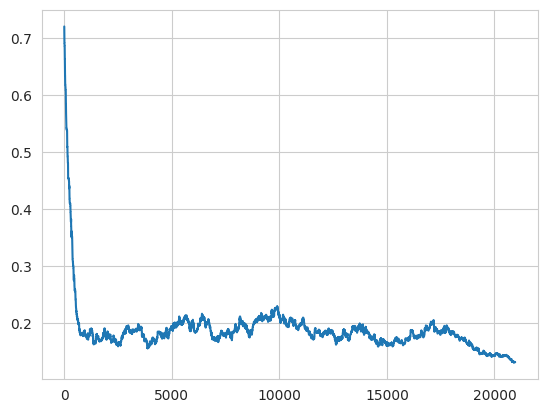

In [ ]:
# можем посмотреть, как менялся вес при подборе, just for fun
plt.plot(values)

In [ ]:
# лучший вес
best_value

0.13152631565856138

In [ ]:
# смотрим, сколько чего он поделил по пропорциям и недоумеваем, почему он не способен сделать так, как мы хотим (ставим на транспорт 0, а 0 получаем в жилой растройке)
luo.to_shares_dict(best_X)

{<LandUse.RESIDENTIAL: 'residential'>: 0.0,
 <LandUse.BUSINESS: 'business'>: 0.06119274559386074,
 <LandUse.RECREATION: 'recreation'>: 0.30266967408045914,
 <LandUse.SPECIAL: 'special'>: 0.13870751180521415,
 <LandUse.INDUSTRIAL: 'industrial'>: 0.1564797521973676,
 <LandUse.AGRICULTURE: 'agriculture'>: 0.2411064967927777,
 <LandUse.TRANSPORT: 'transport'>: 0.09984381953032051}

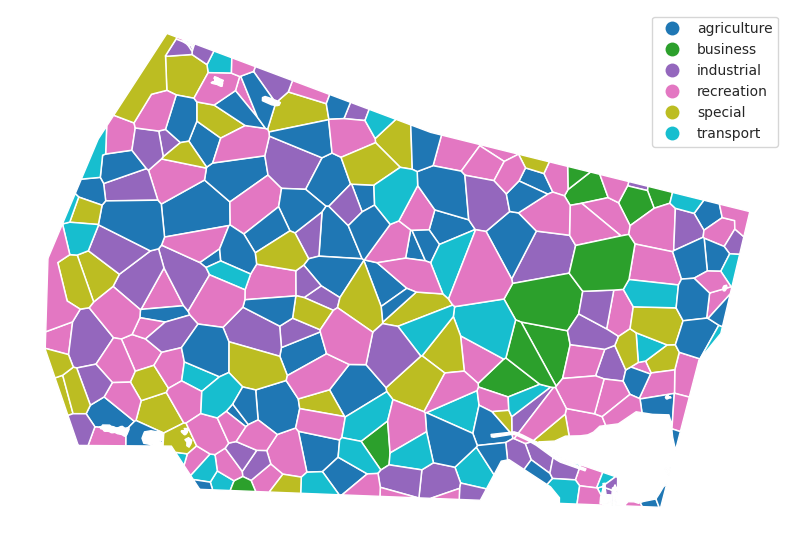

In [ ]:
# наш плот
luo.to_gdf(best_X).plot(column='land_use', legend=True, figsize=(10,10)).set_axis_off()

ПЕРЕДОВОЕ РЕШЕНИЕ ПО РАСПРЕДЕЛЕНИЮ ЛЭНДЮЗА ИМЕНИ НАС

In [ ]:
# правило 1 (не упоминать о Бойцовском клубе): если у нас есть дом, то зона автоматически жилая
# читаем файл
housing = gpd.read_file(os.path.join(data_path, 'housing.geojson')).to_crs(local_crs)
# задаём само правило
for index, block in blocks_gdf.iterrows():
    if housing.geometry.intersects(block.geometry).any():
        blocks_gdf.at[index, 'land_use'] = 'RESIDENTIAL'

# Справка:
Пространственный индекс - это структура данных, которая позволяет эффективно запрашивать и искать пространственные данные (например, точки, линии и полигоны) в географическом наборе данных. Это повышает скорость выполнения пространственных операций, таких как пересечение, локализация и идентификация соседей, за счет сокращения количества необходимых сравнений.

In [ ]:
# правило 2 (не упоминать нигде о Бойцовском клубе): задаём возможных соседей нашему блоку
# создаём spatial index для эффективности
block_sindex = blocks_gdf.sindex
# задаём сами правила
def check_neighbors(block, assigned_use):
    neighbors = blocks_gdf[blocks_gdf.geometry.touches(block.geometry)]
    incompatible_neighbors = {
        'RESIDENTIAL': ['INDUSTRIAL', 'SPECIAL'],
        'INDUSTRIAL': ['RESIDENTIAL', 'AGRICULTURE'],
        'AGRICULTURE': ['INDUSTRIAL', 'SPECIAL'],
        'SPECIAL': ['RESIDENTIAL', 'AGRICULTURE']
    }
    for _, neighbor in neighbors.iterrows():
        if neighbor['land_use'] in incompatible_neighbors.get(assigned_use, []):
            return False
    return True

In [ ]:
# правило 3: лимиты по зонам
MAX_LAND_USE = {
    'RECREATION': 20,
    'SPECIAL': 5,
    'INDUSTRIAL' : 3,
    'AGRICULTURE' : 4,
    'BUSINESS' : 70
    }

In [ ]:
# делим на пропорции наши зоны. транспорта на этом этапе нет, потому что он строится по дорогам, а не по блокам
land_use_distribution = {
    'RESIDENTIAL': 0.71,
    'BUSINESS': 0.13,
    'RECREATION': 0.18,
    'INDUSTRIAL': 0.03,
    'AGRICULTURE': 0.02,
    'SPECIAL': 0.04
}
# пишем функцию по распределению лэндюза
def assign_land_use():
    unassigned_blocks = blocks_gdf[blocks_gdf['land_use'].isna()].index.tolist()
    total_blocks = len(unassigned_blocks)

    # коррекция распределения, на всякий пожарный
    assigned_count = {
        k: min(int(v * total_blocks), MAX_LAND_USE.get(k, float('inf')))
        for k, v in land_use_distribution.items()
    }

    # распределение лэндюза, учитывая лимиты
    for land_use, count in assigned_count.items():
        assigned = 0
        for idx in unassigned_blocks:
            if assigned >= count:
                break
            block = blocks_gdf.loc[idx]
            if check_neighbors(block, land_use):  # Ensure neighbor compatibility
                blocks_gdf.at[idx, 'land_use'] = land_use
                assigned += 1


In [ ]:
# правило 4: обязываем наличие агрикультуры и индустриальных зон
def assign_mandatory_zones():
    # сельское хозяйство
    agriculture_blocks = blocks_gdf[blocks_gdf['land_use'].isna()].sample(frac=land_use_distribution['AGRICULTURE'])
    blocks_gdf.loc[agriculture_blocks.index, 'land_use'] = 'AGRICULTURE'

    # индустриальные зоны
    industrial_blocks = blocks_gdf[blocks_gdf['land_use'].isna()].sample(frac=land_use_distribution['INDUSTRIAL'])
    blocks_gdf.loc[industrial_blocks.index, 'land_use'] = 'INDUSTRIAL'

    # рекреация
    industrial_blocks = blocks_gdf[blocks_gdf['land_use'].isna()].sample(frac=land_use_distribution['RECREATION'])
    blocks_gdf.loc[industrial_blocks.index, 'land_use'] = 'RECREATION'
assign_mandatory_zones()

In [ ]:
# запускаем функцию распределения
assign_land_use()

# остатки заполняем жилой зоной
blocks_gdf['land_use'] = blocks_gdf['land_use'].fillna('BUSINESS')

In [ ]:
# определяем блоки с жилой застройкой и промышленностью
residential_blocks = blocks_gdf[blocks_gdf['land_use'] == 'RESIDENTIAL']
industrial_blocks = blocks_gdf[blocks_gdf['land_use'] == 'INDUSTRIAL']

# лист конфликтующих блоков
conflicts = []

# ищем ситуации соседства жилой застройки и промышленности
for res_idx, res_row in residential_blocks.iterrows():
    for ind_idx, ind_row in industrial_blocks.iterrows():
        if res_row.geometry.touches(ind_row.geometry):
            conflicts.append((res_idx, ind_idx))

# решаем конфликтик
for res_idx, ind_idx in conflicts:
    print(f"Conflict detected between RESIDENTIAL block {res_idx} and INDUSTRIAL block {ind_idx}")
    # в месте конфликта впиндюриваем бизнес
    blocks_gdf.loc[res_idx, 'land_use'] = 'BUSINESS'


Conflict detected between RESIDENTIAL block 100 and INDUSTRIAL block 3
Conflict detected between RESIDENTIAL block 227 and INDUSTRIAL block 285


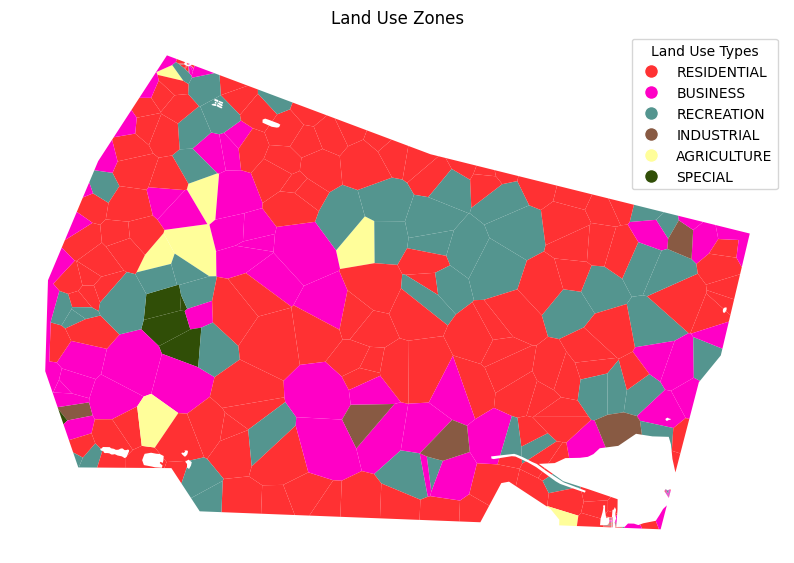

In [ ]:
# строим плот, учитывая типичные цвета из генплана, потому что мы душнилы
land_use_colors = {
    'RESIDENTIAL': '#FF3133',
    'BUSINESS': '#ff00c6',
    'RECREATION': '#54958f',
    'INDUSTRIAL': '#885a43',
    'AGRICULTURE': '#fffe9a',
    'SPECIAL': '#304e07',
}
blocks_gdf['color'] = blocks_gdf['land_use'].map(land_use_colors)

fig, ax = plt.subplots(figsize=(10, 10))
blocks_gdf.plot(ax=ax, color=blocks_gdf['color'])
# Create a legend based on the land use types
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
           for color in land_use_colors.values()]
labels = list(land_use_colors.keys())
ax.legend(handles=handles, labels=labels, title="Land Use Types", loc="upper right")
ax.set_title("Land Use Zones")
ax.set_axis_off()
plt.show()

In [ ]:
#создаём функцию проверки распределения лэндюза
def random_assign_land_use():
    unassigned_blocks = blocks_gdf[blocks_gdf['land_use'].isna()].index.tolist()
    random.shuffle(unassigned_blocks)  # Shuffle to assign randomly
    for idx in unassigned_blocks:
        block = blocks_gdf.loc[idx]
        blocks_gdf.at[idx, 'land_use'] = random.choice(list(land_use_distribution.keys()))

In [ ]:
# смотрим распределение
random_assign_land_use()
print(blocks_gdf['land_use'].value_counts())

land_use
RESIDENTIAL    245
BUSINESS       127
RECREATION      93
INDUSTRIAL      13
AGRICULTURE     12
SPECIAL          5
Name: count, dtype: int64


In [ ]:
# если что-то меняем, то надо сбрасывать лэндюз и запускать заново
blocks_gdf['land_use'] = None

In [ ]:
blocks_gdf_lu = blocks_gdf.set_crs(32636)

# качаем файлик
output_file = 'blocks_lu.geojson'
blocks_gdf_lu.to_file(output_file, driver='GeoJSON')

print(f'GeoJSON file saved with CRS 32636 as {output_file}')

GeoJSON file saved with CRS 32636 as blocks_lu.geojson


С ДНЁМ СТРОИТЕЛЬСТВА ДОРОГ!

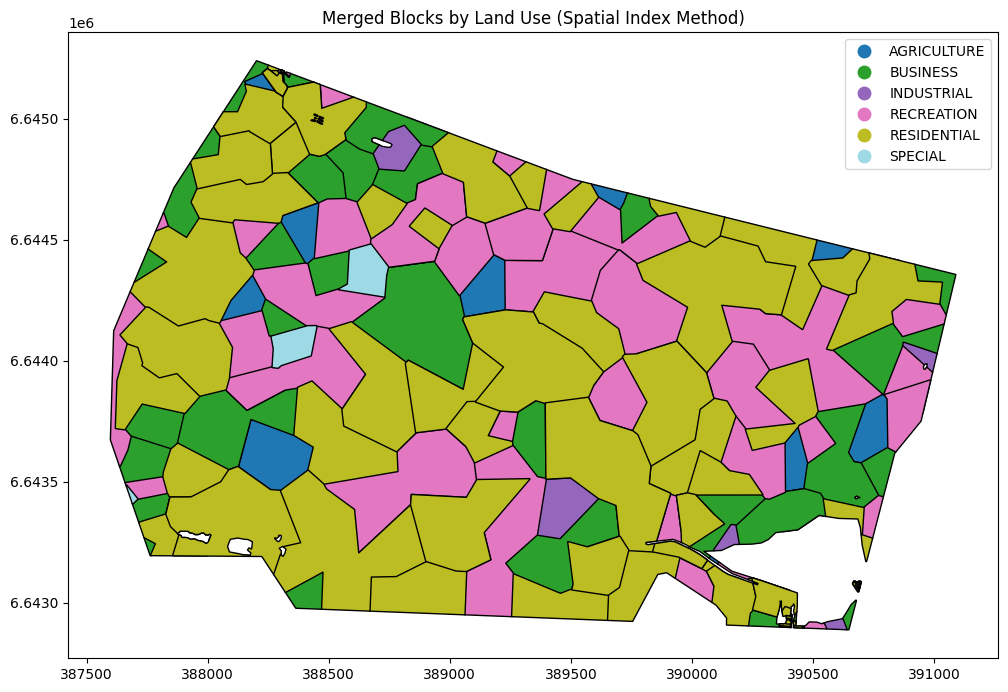

In [ ]:
# проверяем геометрию и строем буферные зоны вокруг блоков лэндюза, чтобы они слиплись
blocks_gdf['geometry'] = blocks_gdf['geometry'].buffer(0)
buffer_blocks = blocks_gdf
buffer_blocks['geometry'] = buffer_blocks['geometry'].buffer(2)


# создаём лист для слипшихся блоков
merged_blocks = []

# мутим всё через спашиал индекс
for land_use, subset in buffer_blocks.groupby('land_use'):
    subset = subset.reset_index(drop=True)
    sindex = subset.sindex

    seen = set()
    for i, geom in subset.geometry.items():
        if i in seen:
            continue
        # ищем соседей через спашиал индекс
        possible_matches = list(sindex.query(geom, predicate='intersects'))
        merged_geom = unary_union(subset.geometry.iloc[possible_matches])
        merged_blocks.append({'land_use': land_use, 'geometry': merged_geom})
        seen.update(possible_matches)

# делаем гдф
merged_blocks_gdf = gpd.GeoDataFrame(merged_blocks, crs=blocks_gdf.crs)

# плот результатов
fig, ax = plt.subplots(figsize=(12, 12))
merged_blocks_gdf.plot(ax=ax, column='land_use', legend=True, cmap='tab20', edgecolor='black')
plt.title('Merged Blocks by Land Use (Spatial Index Method)')
plt.show()

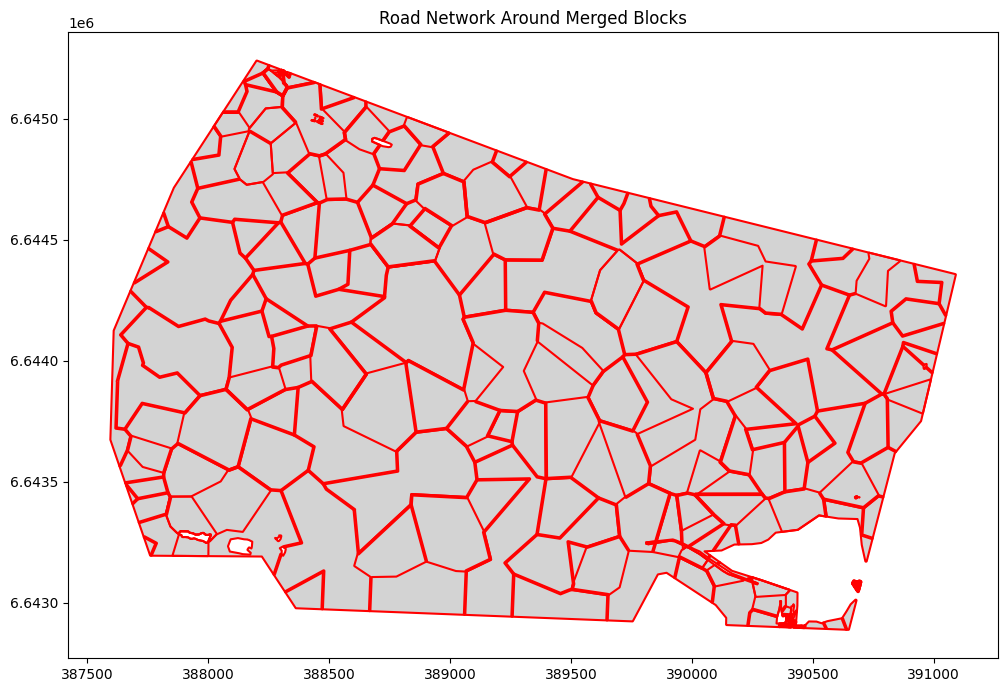

In [ ]:
# новый лист для дорог
roads = []

# пороговое состояние (?) для создания дорог
distance_threshold = 1  # Adjust the threshold as needed

# через слипшиеся блоки с зонами строим дороги вокруг них
for i, merged_block in merged_blocks_gdf.iterrows():
    merged_geom = merged_block.geometry

    # делаем буфер, чтобы симулировать дорогу
    road_buffer = merged_geom.buffer(distance_threshold)

    # создаём дорогу, извлекая границы буфера
    road = road_buffer.boundary

    if road.is_valid:
        roads.append(road)

# создаём гдф
roads_gdf = gpd.GeoDataFrame({'geometry': roads}, crs=blocks_gdf.crs)

# плот
fig, ax = plt.subplots(figsize=(12, 12))
merged_blocks_gdf.plot(ax=ax, color='lightgrey')
roads_gdf.plot(ax=ax, color='red')
plt.title('Road Network Around Merged Blocks')
plt.show()

In [ ]:
roads_gdf

,geometry
0,"LINESTRING (389233.779 6644208.046, 389233.778..."
1,"LINESTRING (388243.628 6644257.015, 388243.649..."
2,"LINESTRING (388305.931 6644601.927, 388305.945..."
3,"LINESTRING (390493.668 6644408.635, 390493.618..."
4,"LINESTRING (388304.082 6643460.327, 388304.04 ..."
...,...
187,"LINESTRING (390389.491 6642941.116, 390389.481..."
188,"LINESTRING (390664.193 6643078.961, 390664.183..."
189,"LINESTRING (387712.294 6643431.077, 387712.324..."
190,"LINESTRING (388292.766 6643968.206, 388292.73 ..."


In [ ]:
roads_gdf = roads_gdf.set_crs(32636)

# качаем файлик
output_file = 'roads_line.geojson'
roads_gdf.to_file(output_file, driver='GeoJSON')

print(f'GeoJSON file saved with CRS 32636 as {output_file}')

GeoJSON file saved with CRS 32636 as roads_line.geojson


In [ ]:
roads_poly=roads_gdf.buffer(7)

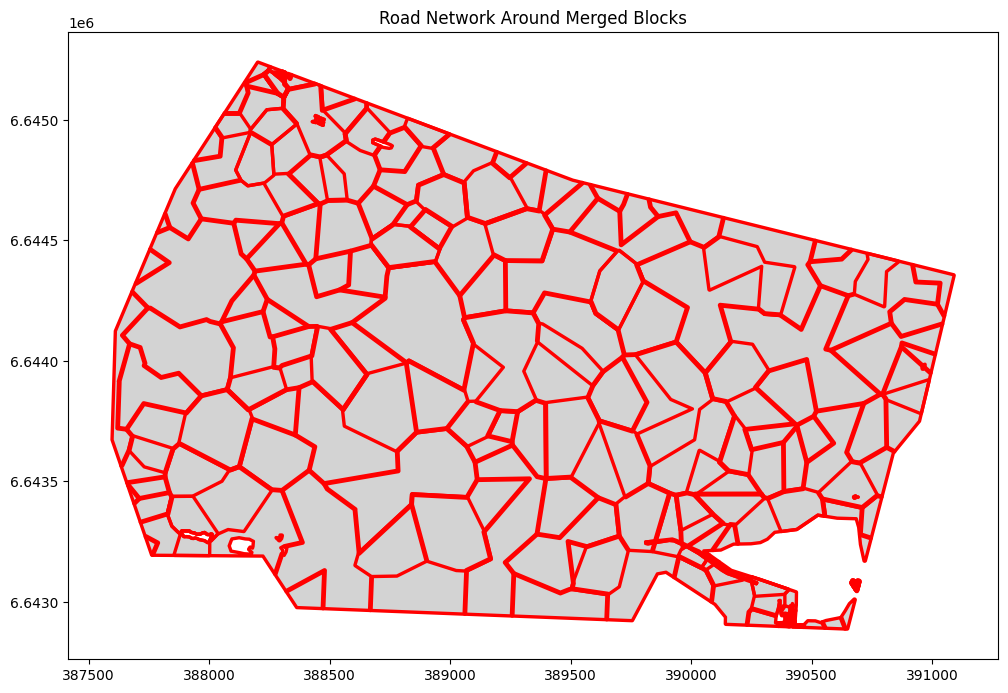

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
merged_blocks_gdf.plot(ax=ax, color='lightgrey')
roads_poly.plot(ax=ax, color='red')
plt.title('Road Network Around Merged Blocks')
plt.show()

In [ ]:
roads_poly

,0
0,"POLYGON ((389240.779 6644208.107, 389240.778 6..."
1,"POLYGON ((388249.762 6644260.388, 388249.839 6..."
2,"POLYGON ((388299.177 6644603.767, 388299.223 6..."
3,"POLYGON ((390494.246 6644401.659, 390494.072 6..."
4,"POLYGON ((388308.256 6643454.707, 388308.112 6..."
...,...
187,"POLYGON ((390382.396 6642940.789, 390382.394 6..."
188,"POLYGON ((390656.808 6643078.361, 390656.743 6..."
189,"POLYGON ((387717.713 6643435.509, 387717.82 66..."
190,"POLYGON ((388297.406 6643962.965, 388297.281 6..."


In [ ]:
roads_poly_u = unary_union(roads_poly.geometry)

In [ ]:
road_poly_u_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(roads_poly_u), crs=roads_gdf.crs)

<ipython-input-257-211180243eec>:5: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


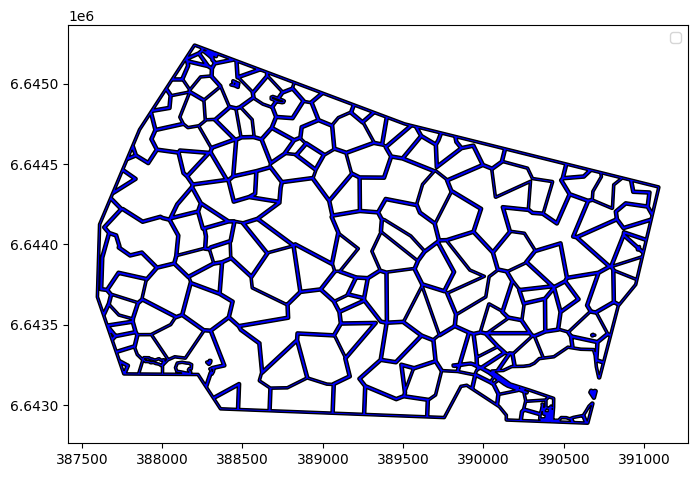

In [ ]:
# плот
fig, ax = plt.subplots(figsize=(8, 8))
road_poly_u_gdf.plot(ax=ax, facecolor='blue', edgecolor='black', label='Roads')

plt.legend()
plt.show()

<Axes: >

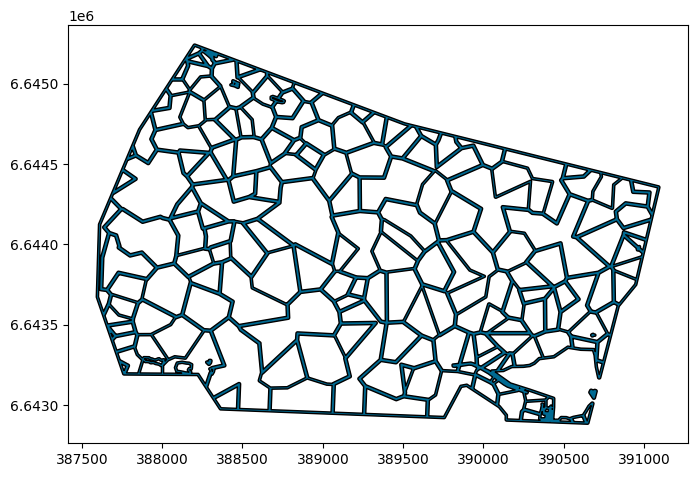

In [ ]:
# создаём колонку лэндюза в файле с дорогами, чтобы добавит функцию транспорта
road_poly_u_gdf['land_use'] = 'TRANSPORT'

# плот
fig, ax = plt.subplots(figsize=(8, 8))
road_poly_u_gdf.plot(ax=ax, facecolor='#006a92', edgecolor='black', label='Roads (TRANSPORT)')


In [ ]:
# добавляем дороги в качестве зоны транспортной инфраструктуры к нашим блокам с лэндюзом
# накладываем дороги на блоки с распределённым лэндюзом
overlay = gpd.overlay(blocks_gdf, road_poly_u_gdf, how='intersection')

# на месте пересечения назначаем лэндюза "транспорт"
overlay['land_use'] = 'TRANSPORT'

# всё, кроме блоков с дорогами
blocks_no_roads = gpd.overlay(blocks_gdf, road_poly_u_gdf, how='difference')

# соединяем
final_blocks_gdf = pd.concat([blocks_no_roads, overlay], ignore_index=True)

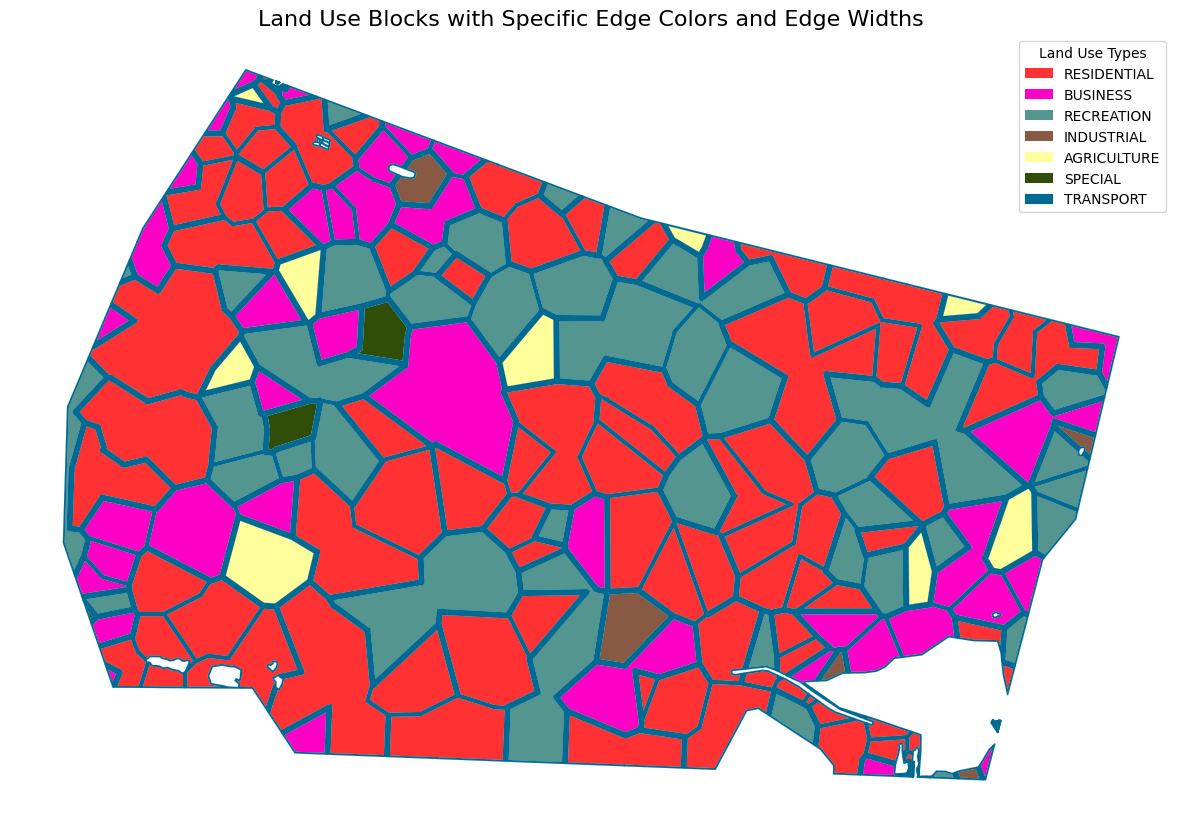

In [ ]:
# определяем цвета блоков, контура и его ширину
land_use_colors = {
    'RESIDENTIAL': '#FF3133',
    'BUSINESS': '#ff00c6',
    'RECREATION': '#54958f',
    'INDUSTRIAL': '#885a43',
    'AGRICULTURE': '#fffe9a',
    'SPECIAL': '#304e07',
    'TRANSPORT': '#006a92'
}

land_use_edge_colors = {
    'RESIDENTIAL': '#FF3133',
    'BUSINESS': '#ff00c6',
    'RECREATION': '#54958f',
    'SPECIAL': '#885a43',
    'INDUSTRIAL': '#fffe9a',
    'AGRICULTURE': '#304e07',
    'TRANSPORT': '#006a92'
}

land_use_edge_widths = {
    'RESIDENTIAL': 0,
    'BUSINESS': 0,
    'RECREATION': 0,
    'SPECIAL':0,
    'INDUSTRIAL': 0,
    'AGRICULTURE': 0,
    'TRANSPORT': 0.1
}

# плотим наш лэндюз и наслаждаемся тем фактом, что у нас всё получилось
fig, ax = plt.subplots(figsize=(15, 15))


for land_use, color in land_use_colors.items():
    edge_color = land_use_edge_colors.get(land_use, 'black')
    edge_width = land_use_edge_widths.get(land_use, 1.0)
    subset = final_blocks_gdf[final_blocks_gdf['land_use'] == land_use]
    subset.plot(ax=ax,
                facecolor=color,
                edgecolor=edge_color,
                linewidth=edge_width)
legend_patches = [mpatches.Patch(facecolor=land_use_colors[land_use],
                                 edgecolor=land_use_edge_colors[land_use],
                                 linewidth=land_use_edge_widths[land_use],
                                 label=land_use)
                  for land_use in land_use_colors.keys()]
ax.legend(handles=legend_patches, loc='upper right', title='Land Use Types')

ax.axis('off')

plt.title('Land Use Blocks with Specific Edge Colors and Edge Widths', fontsize=16)

plt.show()

In [ ]:
# устанавливаем систему координат
final_blocks_gdf_crs = final_blocks_gdf.set_crs(32636)

# качаем файлик
output_file = 'landuse6.geojson'
final_blocks_gdf_crs.to_file(output_file, driver='GeoJSON')

print(f'GeoJSON file saved with CRS 32636 as {output_file}')

GeoJSON file saved with CRS 32636 as landuse6.geojson


ТЫ БОЛЬШОЙ МОЛОДЕЦ И ЗАСЛУЖИЛ УПАКОВКУ КУКУРУЗНЫХ ПАЛОЧЕК